In [68]:
# library(scJLIM)
suppressPackageStartupMessages({
    library(devtools)
    load_all('/home/jmitchel/scJLIM/')
    library(SingleCellExperiment)
    library(scater)
    library(cowplot)
    library(parallel)
    library(ACAT)
    library(viridis)
    library(ggrastr)
})

ℹ Loading scJLIM


In [69]:
# first need to setup juliacall package for faster model fits
library(JuliaCall)
julia <- julia_setup(verbose = TRUE)
julia_install_package_if_needed("MixedModels")
julia_install_package_if_needed("RCall")
julia$library("MixedModels")
julia$library("RCall")


In [70]:
# Note above that my julia install is located in:
# /home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin
# Modify the following variable name with the directory of your install location:
julia_dir="/home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin"

In [71]:
# load small simulated dataset with a positive colocalization in one of two cell types
sim_dat_all <- readRDS(file='/home/jmitchel/scJLIM/data/sim_data.rds')

counts_norm <- sim_dat_all[[1]] # scRNA seq normalized and log transformed counts
covar_df <- sim_dat_all[[2]] # scRNA seq metadata with donor and library size covariates (can contain more)
pcs <- sim_dat_all[[3]] # scRNA seq expression PCs
donor_geno_eqtl <- sim_dat_all[[4]] # scRNA donor genotypes (maf > 0.1, but can be different)
main_tr <- sim_dat_all[[5]] # GWAS summary statistics
ref_matrix <- sim_dat_all[[6]] # reference LD matrix
true_ct <- sim_dat_all[[7]] # the preprogrammed cell type labels (unknown in real data)
causal_snp <- sim_dat_all[[8]] # the preprogrammed causal GWAS and eQTL SNP (unknown in real data)
eQTL_group <- sim_dat_all[[9]] # the preprogrammed cell type with the eQTL (unknown in real data)
eQTL_gene <- sim_dat_all[[10]] # the preprogrammed eGene (unknown in real data)


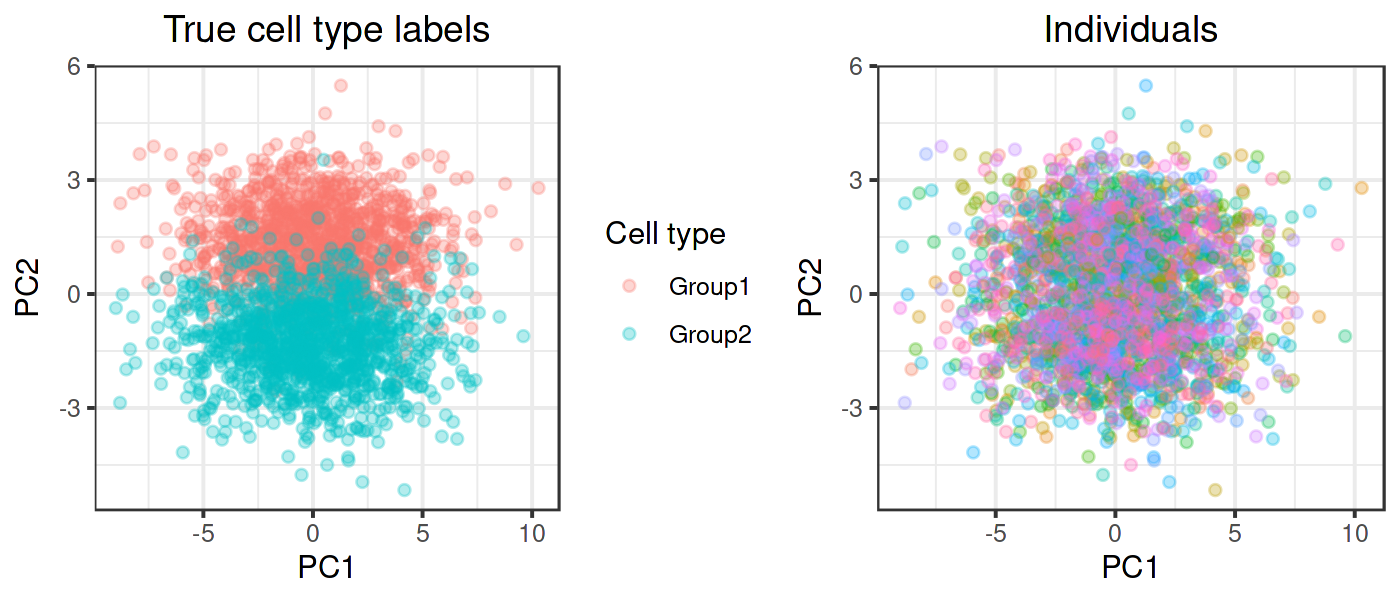

In [72]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)

# looking at the scRNA-seq cell population and donor structure
tmp <- cbind.data.frame(covar_df,true_ct,pcs)
p1 <- ggplot(tmp,aes(x=PC1,y=PC2,color=Group)) + 
    geom_point(alpha=.3) +
    ggtitle('True cell type labels') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(color=guide_legend(title="Cell type"))

p2 <- ggplot(tmp,aes(x=PC1,y=PC2,color=donors)) + 
    geom_point(alpha=.3) + 
    ggtitle('Individuals') +
    theme_bw() +
    theme(legend.position = "none",plot.title = element_text(hjust = 0.5))
plot_grid(p1,p2,nrow=1,rel_widths=c(.57,.45))

# tmp <- cbind.data.frame(covar_df,true_ct,ures[["layout"]])
# colnames(tmp)[4:5] <- c('UMAP1','UMAP2')
# p1 <- ggplot(tmp,aes(x=UMAP1,y=UMAP2,color=cell_type)) +
#   geom_point(alpha=.3) +
#   ggtitle('True cell type labels') +
#   theme_bw() +
#   theme(plot.title = element_text(hjust = 0.5))

# p2 <- ggplot(tmp,aes(x=UMAP1,y=UMAP2,color=donors)) +
#   geom_point(alpha=.3) +
#   ggtitle('Individuals') +
#   theme_bw() +
#   theme(legend.position = "none",plot.title = element_text(hjust = 0.5))
# plot_grid(p1,p2,nrow=1,rel_widths=c(.57,.45))


In [73]:
# In this simple example the top two PCs can separate the cell types fairly well
# Note that it is an imperfect separation, making for a more realistic 
# example where pseudobulk cluster-based eQTL mapping would introduce noise diluting
# the real signal


In [74]:
# # preprocessing the genetics data

# # keep snps with allele frequency over .1
# af <- rowSums(donor_geno_eqtl)/(ncol(donor_geno_eqtl)*2)
# maf <- pmin(af,1-af)
# snps_keep <- names(maf)[maf>=.1]
# donor_geno_eqtl <- donor_geno_eqtl[snps_keep,]

# # reduce both datasets to the intersection of variants
# snps_both <- intersect(rownames(donor_geno_eqtl),rownames(main_tr))
# donor_geno_eqtl <- donor_geno_eqtl[snps_both,]
# main_tr <- main_tr[snps_both,]
# main_tr$CHR <- chr
# main_tr <- main_tr[,c('CHR','position','pval')]
# colnames(main_tr) <- c('CHR','BP','P')


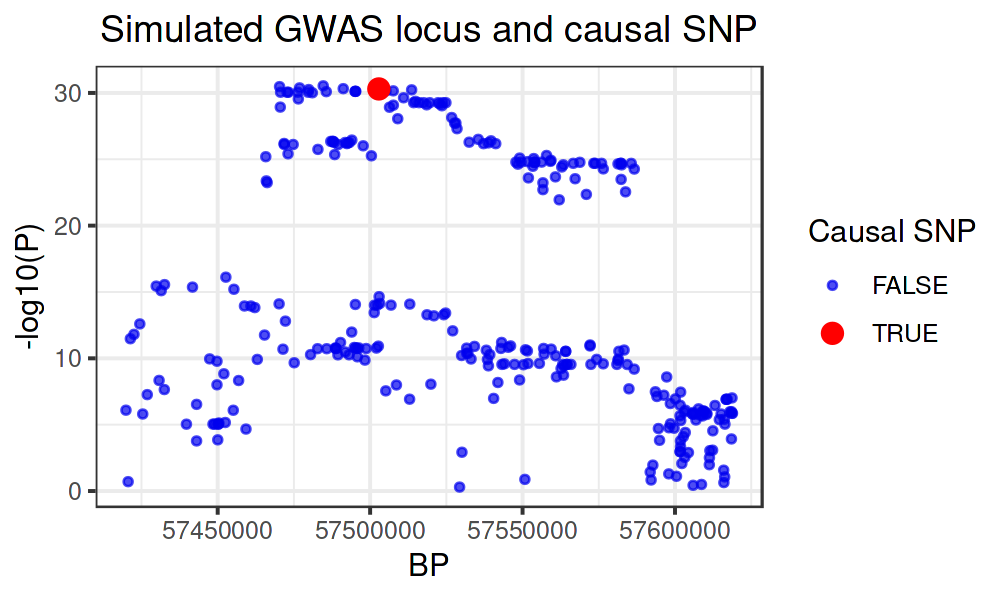

In [75]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

# looking at the simulated GWAS locus
main_tr$causal_snp <- rownames(main_tr)==causal_snp

p <- ggplot(main_tr,aes(x=BP,y=-log10(P),color=causal_snp,size=causal_snp)) +
    geom_point(data=main_tr[which(!main_tr$causal_snp),],alpha=.7) +
    geom_point(data=main_tr[which(main_tr$causal_snp),],alpha=1) +
    scale_size_manual(values = c("TRUE" = 3, "FALSE"=1, 1)) +
    scale_color_manual(values = c("blue2", "red1")) +
    ggtitle('Simulated GWAS locus and causal SNP') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) + 
    guides(color=guide_legend(title="Causal SNP"),size=guide_legend(title="Causal SNP"))
p

# removing the causal SNP label, since we won't know it in real tests
main_tr$causal_snp <- NULL

In [76]:
# We can also see the rsid of the causal SNP
print(paste0('The causal GWAS SNP (red) is: ',causal_snp))

# This SNP was also preprogrammed to be a causal eQTL for gene-018 in the Group2 cell type
print(paste0('This SNP is also an eQTL for ',eQTL_gene,' in the ',eQTL_group,' cell type'))


[1] "The causal GWAS SNP (red) is: rs12916478"
[1] "This SNP is also an eQTL for gene-301 in the Group1 cell type"


In [77]:
# create formatted objects for scJLIM
jlim_vars <- prep_jlim(main_tr,refLD.mat=ref_matrix,min.MAF=0.05)
main_tr <- jlim_vars[[1]]

# create a null distribution from permuted genotypes
nperm <- 100000
null_dist <- get_null_dist(jlim_vars,
                           sectr.sample.size=ncol(donor_geno_eqtl),
                           nperm=nperm,r2res=.8,
                           n.cores=1)

In [78]:
# fit mixed models for each SNP in the locus
n_PCs <- 2 # number of PC interaction terms to use (must be 2 or greater)

# snp_res_mat <- get_eQTL_res(gene_test = eQTL_gene, norm_counts=counts_norm,
#                             cell_meta=covar_df, cell_pcs=pcs, n_PCs,
#                             geno_mat=donor_geno_eqtl, main_tr=main_tr,n.cores=1,
#                             progress=FALSE,
#                             julia_dir=julia_dir)
# compute colocalization p-values per cell and a cauchy (global) p-value over all cells
# jlim_res1 <- jlim_main(snp_res_mat, jlim_vars, null_dist, sectr.sample.size=ncol(donor_geno_eqtl),
#                        min.SNPs.count=15, n.cores=1)
## extract results
# cauchy_all <- jlim_res1[[1]] # global p-value over all cells
# per_cell_pvals <- jlim_res1[[2]] # p-values for all individual cells


snp_res_mat <- get_eQTL_res(gene_test = eQTL_gene, norm_counts=counts_norm,
                          cell_meta=covar_df, cell_pcs=pcs[,1:n_PCs], n_PCs,
                          geno_mat=donor_geno_eqtl, main_tr=main_tr,n.cores=1,
                          use_ivw=FALSE,progress=FALSE,
                          julia_dir="/home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin")
  
jlim_res1 <- jlim_main(snp_res_mat, jlim_vars, null_dist, sectr.sample.size=ncol(donor_geno_eqtl),
                       min.SNPs.count=15, n.cores=1,global_adjust_method='cauchy',
                      adjust_method='none',cluster_pvals=FALSE,n_eff=NULL,
                      progress=TRUE,censor_cells=TRUE,censor_type='min_pval')


## testing reshuffling high pvals
per_cell_pvals <- jlim_res1[[2]]
per_cell_pvals[per_cell_pvals>.5] <- runif(sum(per_cell_pvals>.5),min=.5,max=1)
per_cell_pvals[per_cell_pvals==0] <- 1/length(null_dist[[1]])
cauchy_all <- ACAT(per_cell_pvals)


Julia version 1.10.4 at location /home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin will be used.

Loading setup script for JuliaCall...

Finish loading setup script for JuliaCall.



In [79]:
print(cauchy_all) # this is the overall p-value indicating that there is colocalization amongst the tested cells

[1] 0.0007272109


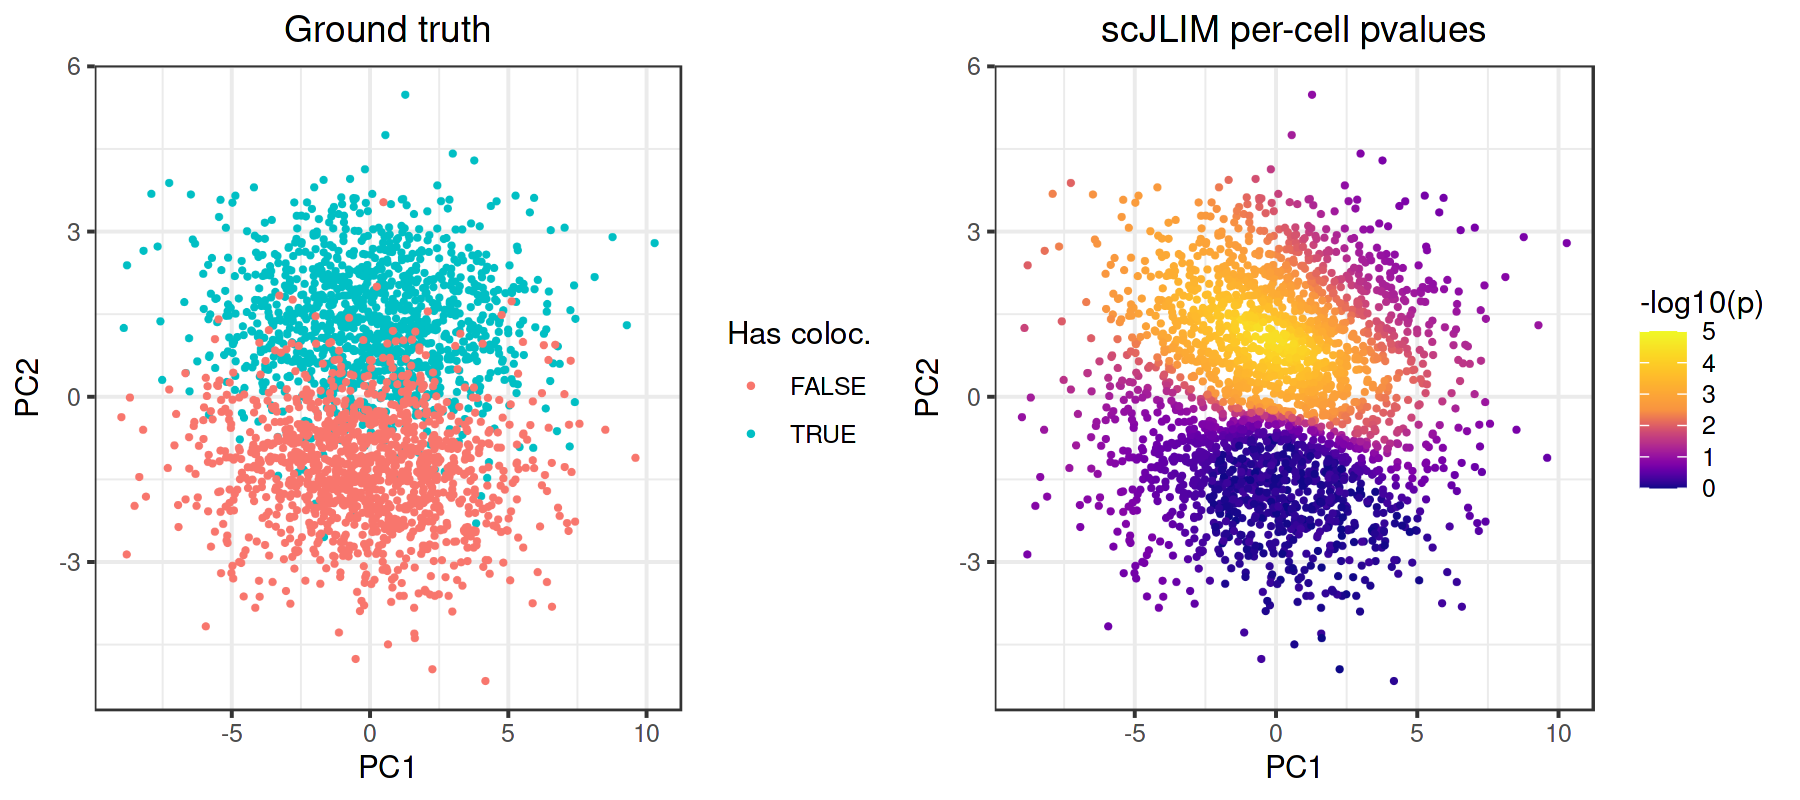

In [80]:
# plotting the per cell pvals to show that it selected the correct cell population

options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 200)

# looking at the scRNA-seq cell population and donor structure
tmp2 <- cbind.data.frame(tmp,per_cell_pvals)
tmp2$true_coloc_cells <- tmp2$Group==eQTL_group

p1 <- ggplot(tmp2,aes(x=PC1,y=PC2,color=true_coloc_cells)) + 
    geom_point_rast(size = .5) +
    ggtitle('Ground truth') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(color=guide_legend(title="Has coloc."))

# p2 <- ggplot(tmp2,aes(x=PC1,y=PC2,color=-log10(per_cell_pvals))) + 
#     geom_point(alpha=.3) + 
#     ggtitle('scJLIM per-cell p-values') +
#     theme_bw() +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     scale_colour_gradientn(name = '-log10(p)',colors = viridis(256,option = "plasma"))

p2 <- ggplot(tmp,aes(x=PC1,y=PC2,color=-log10(per_cell_pvals))) +
  geom_point_rast(size = .5) +
  scale_colour_gradientn(
    colors = viridis(256,option = "plasma"),
    values = scales::rescale(c(0,.15,.35,.5,1)),  # normalize your breakpoints
    limits = c(0, 5)) +
  theme_bw() +
  labs(title = 'scJLIM per-cell pvalues',
       color = "-log10(p)") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.spacing.y = unit(0.1, "cm"),   # reduces vertical spacing between legend items
        legend.key.height = unit(0.4, "cm"),    # decreases the height of the legend key
        legend.key.width = unit(0.6, "cm"))

plot_grid(p1,p2,nrow=1,rel_widths=c(.5,.5))



# library(umap)
# ures <- umap(pcs)
# tmp2 <- cbind.data.frame(tmp2,ures[["layout"]])
# colnames(tmp2)[(ncol(tmp2)-1):ncol(tmp2)] <- c('UMAP1','UMAP2')
# p1 <- ggplot(tmp2,aes(x=UMAP1,y=UMAP2,color=true_coloc_cells)) + 
#     geom_point(alpha=.3) +
#     ggtitle('Ground truth') +
#     theme_bw() +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     guides(color=guide_legend(title="Has coloc."))

# p2 <- ggplot(tmp2,aes(x=UMAP1,y=UMAP2,color=-log10(per_cell_pvals))) + 
#     geom_point(alpha=.3) + 
#     ggtitle('scJLIM per-cell p-values') +
#     theme_bw() +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     scale_colour_gradientn(name = '-log10(p)',colors = viridis(256,option = "plasma"))
# plot_grid(p1,p2,nrow=1,rel_widths=c(.5,.5))


In [67]:

get_acat_cells <- function(pvals,pv_thresh=.1,initial_step_size=1000) {
  pvals[pvals==0] <- 1/100000
  pvals[pvals>.5] <- runif(sum(pvals>.5),min=.5,max=1)
  acat_pv <- ACAT(pvals)
  
  if (acat_pv>pv_thresh) {
    return(NA)
  }
  
  pvals <- pvals[order(pvals,decreasing=FALSE)]
  pvals_sub <- pvals
  
  if (initial_step_size %% 10 != 0) {
    message('rounding initial step size to be divisible by 10')
    initial_step_size <- 10^(floor(log10(initial_step_size)))
  }
  step_sizes_test <- 10^(seq(from = log10(initial_step_size), to = 0, by = -1))
  for (step_size in step_sizes_test) {
    acat_pv <- 0
    while (acat_pv<pv_thresh & length(pvals_sub)>0) {
      acat_pv <- ACAT(pvals_sub)
      pvals_sub <- pvals_sub[-(1:step_size)]
    }
    
    if (length(pvals_sub)==0) { # if it stepped over all the pvals and needs to backtrack only 1
      pvals_sub <- pvals[(length(pvals)-step_size):length(pvals)]
    } else { # need to backtrack by two
      cell_stop <- names(pvals_sub)[1]
      ndx_stop <- which(names(pvals)==cell_stop) - (2*step_size)
      pvals_sub <- pvals[ndx_stop:length(pvals)]
    }
  }
  
  cells_sig <- names(pvals)[1:ndx_stop]
  
  return(cells_sig)
}


In [74]:
# We can also select a discrete population of colocalized cells from the p-values
# by selecting the largest set of top N cells (by smallest p-value) that are required 
# to achieve the global significance

# sig_cells <- get_acat_cells(per_cell_pvals,nperm=nperm,pv_thresh=.1,initial_step_size=1000)

sig_cells <- get_acat_cells(per_cell_pvals,pv_thresh=.1,initial_step_size=100)


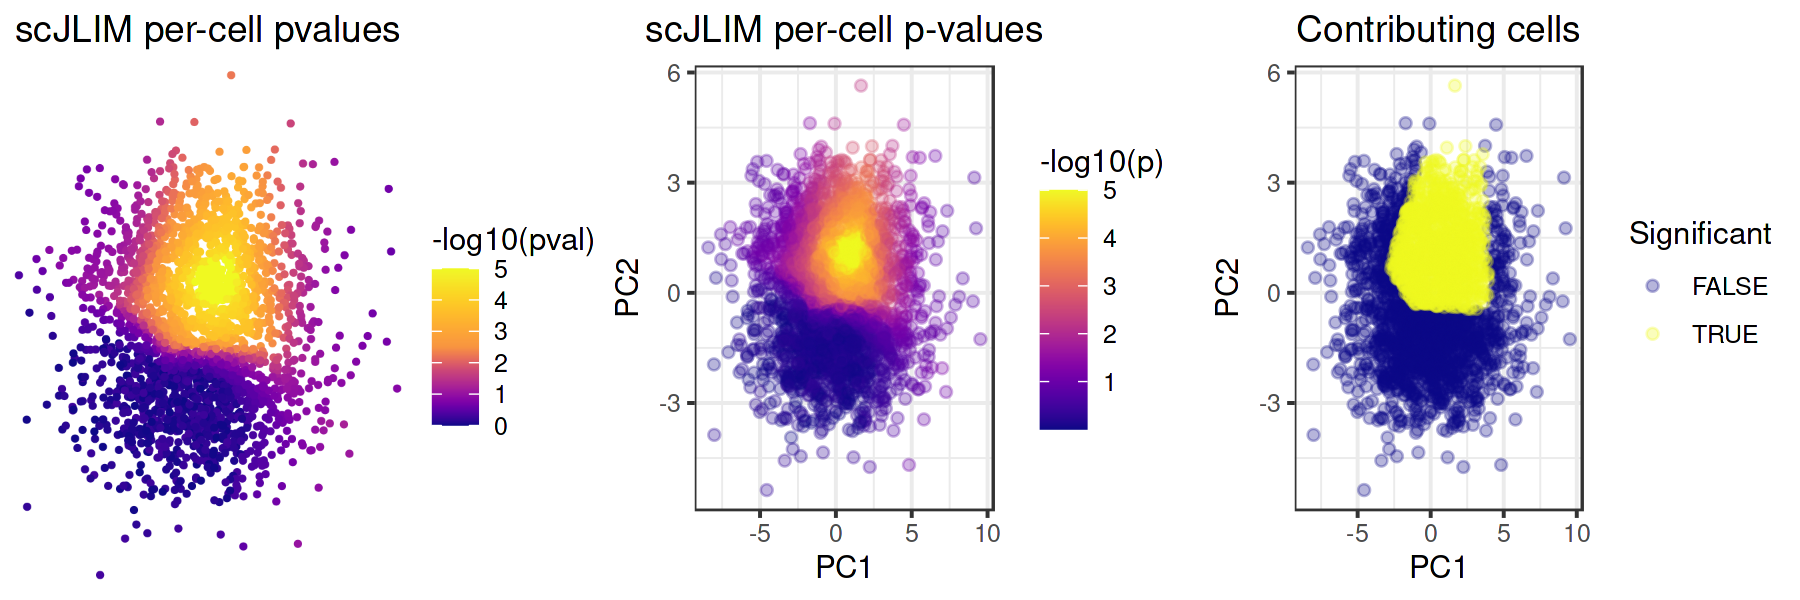

In [75]:
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 200)

tmp2$significant <- rownames(tmp2) %in% sig_cells
p3 <- ggplot(tmp2,aes(x=PC1,y=PC2)) +
  geom_point(data=tmp2[!tmp2$significant,],aes(color=significant),alpha=.3) +
  geom_point(data=tmp2[tmp2$significant,],aes(color=significant),alpha=.3) +
  scale_color_viridis_d(option = "plasma") +
  theme_bw() +
  labs(title = 'Contributing cells',
       color = "Significant") +
  theme(plot.title = element_text(hjust = 0.5))

# p3 <- ggplot(tmp2,aes(x=UMAP1,y=UMAP2)) +
#   geom_point(data=tmp2[!tmp2$significant,],aes(color=significant),alpha=.3) +
#   geom_point(data=tmp2[tmp2$significant,],aes(color=significant),alpha=.3) +
#   scale_color_viridis_d(option = "plasma") +
#   theme_bw() +
#   labs(title = 'Contributing cells',
#        color = "Significant") +
#   theme(plot.title = element_text(hjust = 0.5))
plot_grid(p1,p2,p3,nrow=1)

In [70]:
# running some additional false positive checking
sig_thresh_pv <- .001
pc_flags <- detect_pattern(jlim_res1,pcs,sig_thresh_pv=sig_thresh_pv)
if (length(pc_flags[[1]])>0) { # if we find a PC with the pattern...
  pc_snps <- identify_snps_contrib(jlim_res1,pc_flags,pcs,snp_res_mat,jlim_vars,null_dist,
                                   sectr.sample.size=ncol(donor_geno_eqtl),min.SNPs.count=15,sig_thresh_pv=.001)
  final_flag <- check_snp_direc(snp_res_mat,jlim_vars,pcs,pc_flags,pc_snps)
  final_flag_any <- any(final_flag)
} else {
  final_flag_any <- FALSE
} 
  


In [71]:
ndx_flag <- which(jlim_res1[[1]]<.1)
flag_vec <- c()
for (i in 1:length(jlim_res1[[1]])) {
    if (i %in% ndx_flag) {
      flag_vec <- c(flag_vec,final_flag_any)
    } else {
      flag_vec <- c(flag_vec,NA) # give NA value if the global pv is NS
    }
}

In [72]:
flag_vec

[1] FALSE

In [73]:
final_flag_any

[1] FALSE